In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

from PhicoreModules import parse_genbank, median, mean, stdev, mode
from PhicoreModules import get_features_of_type, get_features_lengths, get_gc_content, get_coding_density, get_distribution_of_stops # Przemek's functions
from PhicoreModules import get_mean_cds_length_rec_window, get_rolling_gc, get_rolling_mean_cds # George's functions
from PhicoreModules import write_df_to_artemis

# Working on STOPs distribution per frame

In [53]:
from typing import Union
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

def get_codon_num_in_frame(seq: Union[str, SeqRecord, Seq], codon: str) -> int:
    """
    Count the number of codons in a sequence in the first frame.
    :param: seq: nucleotide sequence
    :param: codon: codon to count
    :return: number of codons
    """

    codons_num = 0
    for i in range(0, len(seq), 3):
        if seq[i:i+3] == codon:
            codons_num += 1
    return codons_num

def get_distribution_of_stops_per_frame(seqiorec : Union[str, SeqRecord, Seq], strand : int = 1, window : int = 210, step : int = 30):
    """
    Get distribution of stops
    :param seqiorec: nucleotide sequence to be searched
    :param strand: strand to be searched
    :param window: window size to consider
    :param step: step size to consider
    :return:
    """

    # change strand if needed
    if strand == -1:
        seqiorec = seqiorec.reverse_complement()

    stops = ['TAA', 'TAG', 'TGA']

    # the array starts and ends with NaNs because the distribution of certain stop codon is plotted in the middle of the window
    stops_frame_distr = {
        'x': range(1, len(seqiorec.seq) + 1),

        f'{strand}-TAA': [np.NAN]*int(window/2),
        f'{strand}-TAG': [np.NAN]*int(window/2),
        f'{strand}-TGA': [np.NAN]*int(window/2),

        f'{strand * 2}-TAA': [np.NAN]*int(window/2),
        f'{strand * 2}-TAG': [np.NAN]*int(window/2),
        f'{strand * 2}-TGA': [np.NAN]*int(window/2),

        f'{strand * 3}-TAA': [np.NAN]*int(window/2),
        f'{strand * 3}-TAG': [np.NAN]*int(window/2),
        f'{strand * 3}-TGA': [np.NAN]*int(window/2)
    }
    
    i = 0
    while i + window/2 + 3 <= len(seqiorec.seq) - window/2:
        for frame in range(3):
            taa = get_codon_num_in_frame(seqiorec.seq[i + frame : i + window + frame], 'TAA')
            tag = get_codon_num_in_frame(seqiorec.seq[i + frame : i + window + frame], 'TAG')
            tga = get_codon_num_in_frame(seqiorec.seq[i + frame : i + window + frame], 'TGA')
            stops_frame_distr[f'{strand * (frame + 1)}-TAA'].extend([taa]*(step))
            stops_frame_distr[f'{strand * (frame + 1)}-TAG'].extend([tag]*(step))
            stops_frame_distr[f'{strand * (frame + 1)}-TGA'].extend([tga]*(step))
            # print(frame, taa)
        i += step
        
    i -= step
    left = len(stops_frame_distr['x']) - len(stops_frame_distr[f'{strand}-TAA'])
    if left > 0:
        for frame in range(3):
            stops_frame_distr[f'{strand * (frame + 1)}-TAA'].extend([np.NAN]*left)
            stops_frame_distr[f'{strand * (frame + 1)}-TAG'].extend([np.NAN]*left)
            stops_frame_distr[f'{strand * (frame + 1)}-TGA'].extend([np.NAN]*left)

    return pd.DataFrame(stops_frame_distr)

def get_distribution_of_stops_for_all_strands(seqiorec : Union[str, SeqRecord, Seq], window : int = 210, step : int = 30):
    """
    Get distribution of stops for all strands
    :param seqiorec: nucleotide sequence to be searched
    :param window: window size to consider
    :param step: step size to consider
    :return:
    """

    # positive strand
    dfp = get_distribution_of_stops_per_frame(seqiorec, 1, window, step)
    # negative strand
    dfn = get_distribution_of_stops_per_frame(seqiorec, -1, window, step)
    dfn.sort_values(by="x", ascending=False, ignore_index=True, inplace=True)
    dfn.drop('x', axis=1, inplace = True)
    df = pd.concat([dfp, dfn], axis=1)

    return df

In [56]:
infiles = [
    './genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TAG-TGA-TAA.gbk',
    './genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TGA-TAA.gbk',
]
window = 2000
step = 30
for infile in infiles[:1]:
    for record in parse_genbank(infile):
        df = get_distribution_of_stops_for_all_strands(record, window, step)

/home/dec/miniconda3/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1555: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(


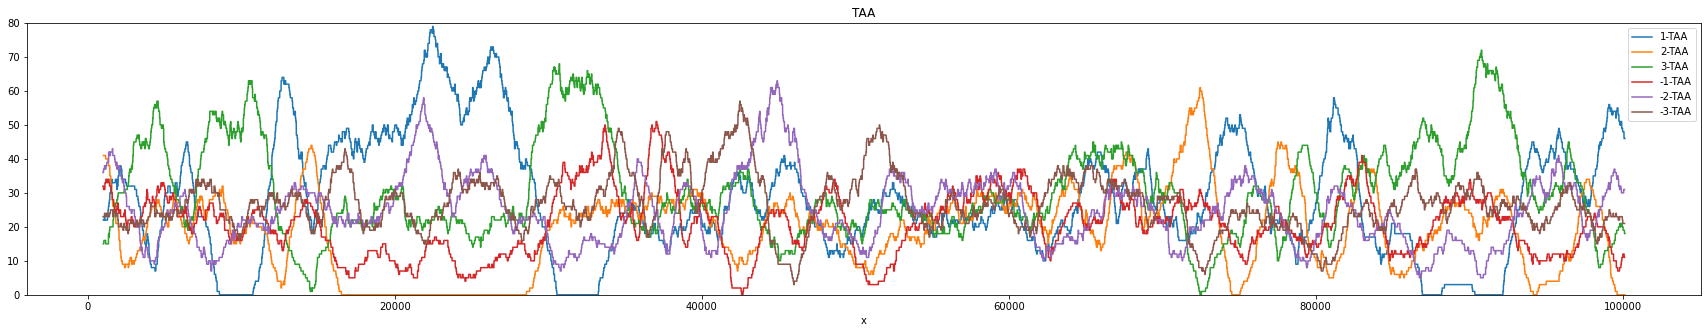

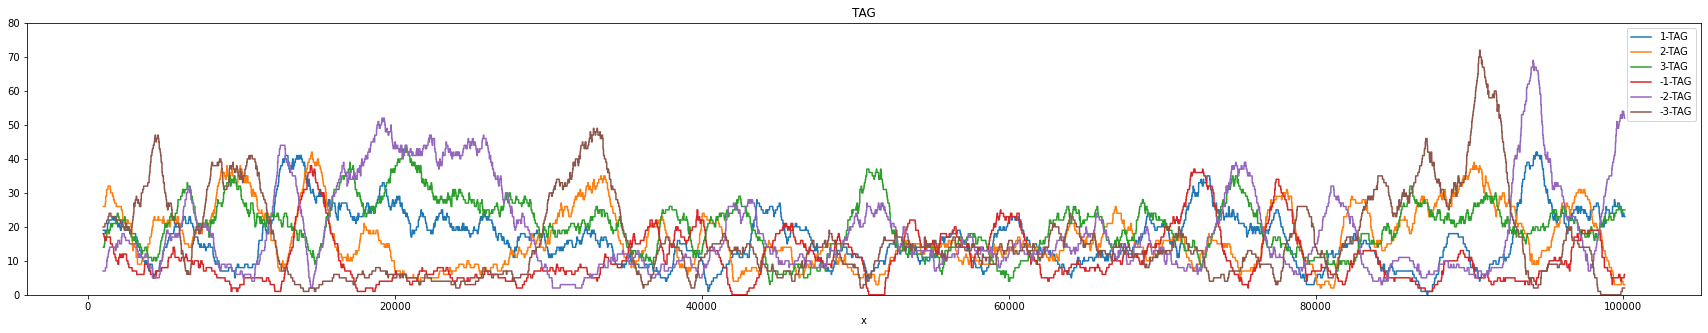

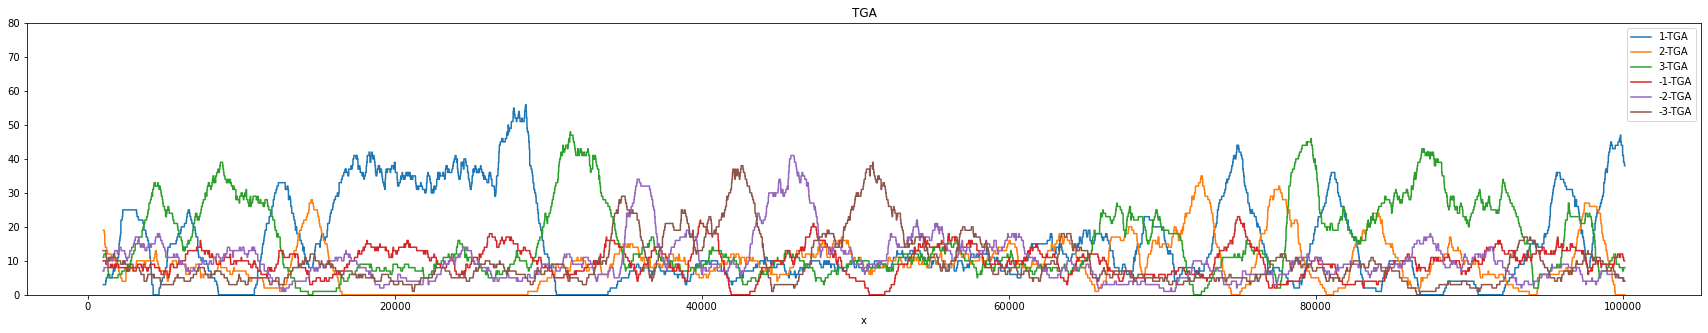

In [57]:
# plot per STOP codon
stops = ['TAA', 'TAG', 'TGA']
for stop in stops:
    to_keep = ['x'] + [col for col in df.columns if stop in col]
    df[to_keep].plot(x='x', figsize=(30, 5), title=stop, ylim = (0, 80))   


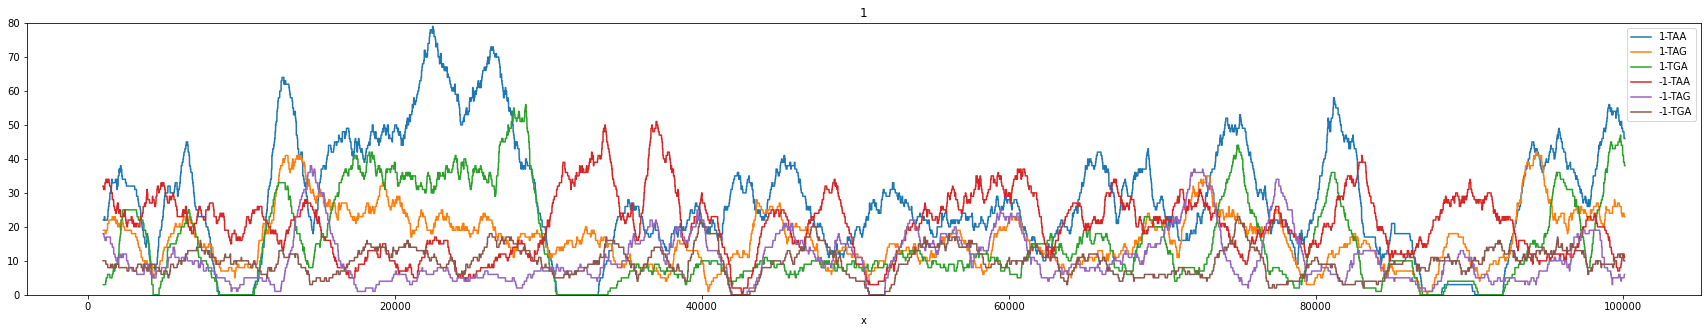

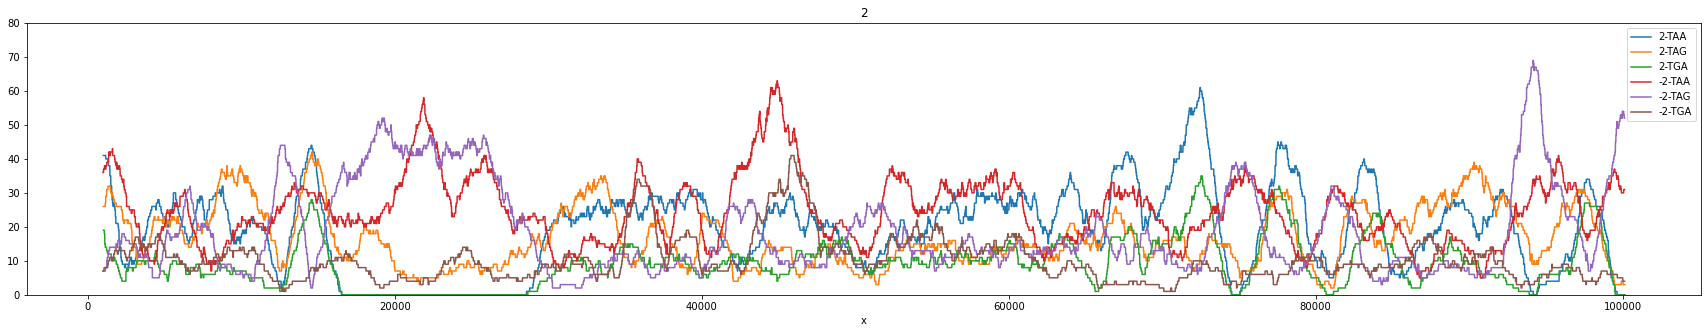

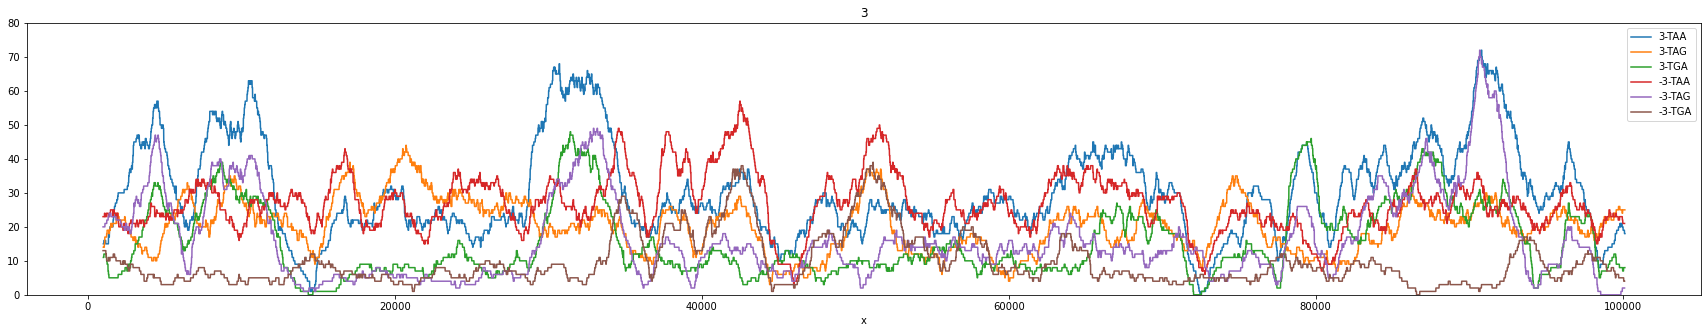

In [58]:
# plot per frame codon
frames = ['1', '2', '3']
for frame in frames:
    to_keep = ['x'] + [col for col in df.columns if frame in col]
    df[to_keep].plot(x='x', figsize=(30, 5), title=frame, ylim = (0, 80))

# Get plots to Artemis - we need smaller window size

In [252]:
window = 300
step = 30
print("Working of STOPs distibution")
for infile in infiles[:1]:
    for record in parse_genbank(infile):
        df = get_distribution_of_stops_for_all_strands(record, window, step)


# per stop codon
stops = ['TAA', 'TAG', 'TGA']
for stop in stops:
    to_keep = ['x'] + [col for col in df.columns if stop in col]
    # df[to_keep].plot(x='x', figsize=(30, 5), title=stop, ylim = (0, 80))   
    output = f'./tmp/UAG_{stop}.txt'
    print(f"Writing {output}")
    write_df_to_artemis(df[to_keep], output)

# per frame
frames = ['1', '2', '3'] #, '-1', '-2', '-3']
for frame in frames:
    to_keep = ['x'] + [col for col in df.columns if col.startswith(frame)]
    # df[to_keep].plot(x='x', figsize=(30, 5), title=frame, ylim = (0, 80))
    output = f'./tmp/UAG_{frame}.txt'
    print(f"Writing {output}")
    write_df_to_artemis(df[to_keep], output)

# all options
output = f'./tmp/UAG_all.txt'
print(f"Writing {output}")
write_df_to_artemis(df, output)

Working of STOPs distibution


/home/dec/miniconda3/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1555: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(


Writing ./tmp/UAG_TAA.txt
Writing ./tmp/UAG_TAG.txt
Writing ./tmp/UAG_TGA.txt
Writing ./tmp/UAG_1.txt
Writing ./tmp/UAG_2.txt
Writing ./tmp/UAG_3.txt
Writing ./tmp/UAG_all.txt


# Entropy

In [248]:
from scipy.stats import entropy
from typing import List
# take a window of sequence in a certain frame and take the list of all STOP codons occuring in that window
# calculate their frequency and calculate the entropy of that distribution

def filter_codons(seqiorec : Union[str, SeqRecord, Seq], codons : List[str] = ['TAA', 'TAG', 'TGA']):
    """
    Get only stops from a sequence
    :param seqiorec: nucleotide sequence to be searched
    :return:
    """

    if isinstance(seqiorec, SeqRecord):
        seq = str(seqiorec.seq)
    elif isinstance(seqiorec, Seq):
        seq = str(seqiorec)
        
    selected_codons = []
    for codon in [seq[i:i+3] for i in range(0, len(seq), 3)]:
        if codon in codons:
            selected_codons.append(codon)

    return selected_codons

def encode_codons(codons : List[str]):
    """
    Encode codons as integers
    :param codons: list of codons
    :return:
    """
    codon2int = {codon : i for i, codon in enumerate(set(codons))}

    return [codon2int[codon] for codon in codons]

def probability_of_codons(codons : List[str]):
    """
    Get frequency of codons
    :param codons: list of codons
    :return:
    """
    
    probability = []
    for codon in set(codons):
        probability.append(1/codons.count(codon))

    return probability

def get_entropy_of_stops_per_frame(seqiorec : Union[str, SeqRecord, Seq], strand : int = 1, window : int = 210, step : int = 30):
    """
    Get entropy of STOPs
    :param seqiorec: nucleotide sequence to be searched
    :param strand: strand to be searched
    :param window: window size to consider
    :param step: step size to consider
    :return:
    """

    # change strand if needed
    if strand == -1:
        seqiorec = seqiorec.reverse_complement()

    stops = ['TAA', 'TAG', 'TGA']

    # the array starts and ends with NaNs because the distribution of certain stop codon is plotted in the middle of the window
    stops_frame_entropy = {
        'x': range(1, len(seqiorec.seq) + 1),

        f'{strand}-H1': [np.NAN]*int(window/2),
        f'{strand}-H2': [np.NAN]*int(window/2),
        f'{strand}-H3': [np.NAN]*int(window/2),
    }
    
    i = 0
    while i + window/2 + 3 <= len(seqiorec.seq) - window/2:

        for frame in range(3):
            # get the stops that occur in sequence window
            frame_stops = filter_codons(seqiorec.seq[i + frame : i + window + frame], stops)
            # calculate the entropy of the these stops
            if len(frame_stops) > 1:
                frame_H = entropy(probability_of_codons(frame_stops))
            else:
                frame_H = 0
            # save result
            stops_frame_entropy[f'{strand}-H{(frame + 1)}'].extend([frame_H]*(step))
        i += step
    
    i -= step
    left = len(stops_frame_entropy['x']) - len(stops_frame_entropy[f'{strand}-H1'])
    if left > 0:
        for frame in range(3):
            stops_frame_entropy[f'{strand}-H{(frame + 1)}'].extend([np.NAN]*left)

    return pd.DataFrame(stops_frame_entropy)

def get_entropy_of_stops_for_all_strands(seqiorec : Union[str, SeqRecord, Seq], window : int = 210, step : int = 30):
    """
    Get entropy of stops for all strands
    :param seqiorec: nucleotide sequence to be searched
    :param window: window size to consider
    :param step: step size to consider
    :return:
    """

    # positive strand
    dfp = get_entropy_of_stops_per_frame(seqiorec, 1, window, step)
    # negative strand
    dfn = get_entropy_of_stops_per_frame(seqiorec, -1, window, step)
    dfn.sort_values(by="x", ascending=False, ignore_index=True, inplace=True)
    dfn.drop('x', axis=1, inplace = True)
    df = pd.concat([dfp, dfn], axis=1)

    return df

# Produce entropy plot for Artemis

Writing ./tmp/UAG_entropy-w300-s30.txt


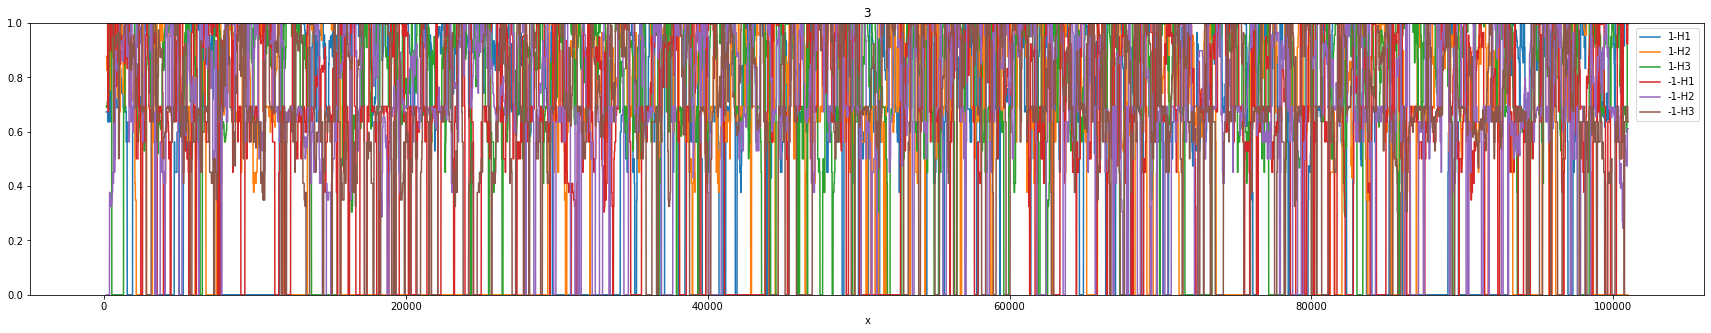

In [251]:
window = 300
for step in [30]:
    df = get_entropy_of_stops_for_all_strands(record, window, step)
    df.plot(x='x', figsize=(30, 5), title=frame, ylim = (0, 1))
    output_path = f'./tmp/UAG_entropy-w{window}-s{step}.txt'
    print(f"Writing {output_path}")
    write_df_to_artemis(df, output_path)

# A nice example
1. Open the following two entries in Artemis
    - './genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TAG-TGA-TAA.gbk'
    - './genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TGA-TAA.gbk'
2. Add user plot: UAG_entropy-w300-s30.txt
3. Add user plot: UAG_1.txt
4. Move around the genome

# Get all basic stats for a single genome

In [68]:
from typing import List

def get_all_stats(infile : str, outdir : str, plot : List[str] = 0,  write : List[str] = []):
    """
    Prints all stats we have so far on a single file
    :param infile: path to input file
    :param outdir: path to output directory
    :param plot: which plots to generate
    :param write: which stats and plots to write to file
    :return:
    """

    stats = {
        'infile': infile,
        'id': '', 
        'length': 0, 
        'gc': 0, 
        'cds_num': 0, 
        'cds_avg_len': 0, 
        'cds_med_len': 0, 
        'cds_tRNA_density': 0, 

    }

    print("=== Working on file {} ===".format(infile))
    for record in parse_genbank(infile):
        stats['id'] = record.id
        stats['length'] = len(record.seq)
        stats['gc'] = get_gc_content(record.seq)
        cdss = get_features_of_type(record, 'CDS')
        cdss_lengths = get_features_lengths(record, 'CDS')
        stats['cds_num'] = len(cdss)
        stats['cds_avg_len'] = mean(cdss_lengths)
        stats['cds_med_len'] = median(cdss_lengths)
        stats['cds_tRNA_density'] = get_coding_density(record, ['CDS', 'tRNA'])

        # output files
        df_stops_file = os.path.join(outdir, '{}.{}_stops.txt'.format(os.path.basename(infile), record.id))
        df_stops_per_frame_file = os.path.join(outdir, '{}.{}_stops_per_frame.txt'.format(os.path.basename(infile), record.id))
        df_stops_plot_file = os.path.join(outdir, '{}.{}_stops.png'.format(os.path.basename(infile), record.id))
        df_stops_per_frame_plot_file = os.path.join(outdir, '{}.{}_stops_per_frame.png'.format(os.path.basename(infile), record.id))
        # data
        window = 300
        step = 30

        if plot or write:
            print(" = Getting overall distribution of stops")
            df = get_distribution_of_stops(record, window, step)
            if 'stop_distr' in plot:
                df.plot(
                    x="x", 
                    y=df.columns[1:], 
                    figsize=(40, 8), 
                    legend=True, 
                    title="{} - {} # window: {}, step: {}".format(os.path.basename(infile), record.id, window, step)
                )
            if 'stop_distr' in write:
                print("Writing distribution of stops to {}".format(df_stops_file))
                write_df_to_artemis(df, df_stops_file)
                print("Writing plot of the distribution to {}".format(df_stops_plot_file))
                plt.savefig(df_stops_plot_file)

            if 'stop_distr_per_frame' in plot:
                print(" = Getting distribution of stops per frame")
                df = get_distribution_of_stops_per_frame(record, window, step)
                df.plot(
                    x="x", 
                    y=df.columns[1:], 
                    figsize=(40, 8), 
                    legend=True, 
                    title="{} - {} # window: {}, step: {}".format(os.path.basename(infile), record.id, window, step)
                )
            if 'stop_distr_per_frame' in write:
                print("Writing distribution of stops to {}".format(df_stops_file))
                write_df_to_artemis(df, df_stops_per_frame_file)
                print("Writing plot of the distribution to {}".format(df_stops_plot_file))
                plt.savefig(df_stops_per_frame_plot_file)
    
    return stats


In [70]:
infiles = glob.glob('./genbank/UAG*')
outdir = './tmp'
df = pd.DataFrame()
for infile in infiles:
    df = df.append(get_all_stats(infile, outdir), ignore_index=True)

df

# for record in parse_genbank('./genbank/OFRY01000050-TAG-TGA-TAA.gbk'):
#     df_all = get_rolling_mean_cds(record, window=1000, step=30)
# for record in parse_genbank('./genbank/OFRY01000050-TGA-TAA.gbk'):
#     df_tag = get_rolling_mean_cds(record, window=1000, step=30)
# for record in parse_genbank('./genbank/OFRY01000050-TAG-TAA.gbk'):
#     df_tga = get_rolling_mean_cds(record, window=1000, step=30)
# for record in parse_genbank('./genbank/OFRY01000050-TAG-TGA.gbk'):
#     df_taa = get_rolling_mean_cds(record, window=1000, step=30)


# df_all['No_TAG'] = df_tag['Mean_CDS']
# df_all['No_TGA'] = df_tga['Mean_CDS']
# df_all['No_TAA'] = df_taa['Mean_CDS']

# # df_tag['Mean_CDS_all'] = df_all['Mean_CDS']
# df_all.plot(x="x", y=["Mean_CDS", "No_TAG", "No_TGA", "No_TAA"], figsize=(40, 8))

# # df_tag['Delta'] = df_tag['Mean_CDS'] - df_tag['Mean_CDS_all']

# outfile = './tmp/OFRY01000050-TAG-TGA-TAA.gbk.cds_distr_w1000_s30.txt'
# write_df_to_artemis(df_all, outfile)

=== Working on file ./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TAA.gbk ===
=== Working on file ./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TAG-TAA.gbk ===
=== Working on file ./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TAG-TGA-TAA.gbk ===
=== Working on file ./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TAG-TGA.gbk ===


/home/dec/miniconda3/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1555: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(
/tmp/ipykernel_9955/2082699971.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(get_all_stats(infile, outdir), ignore_index=True)
/home/dec/miniconda3/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1555: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(
/tmp/ipykernel_9955/2082699971.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(get_all_stats(infile, outdir), ignore_index=True)
/home/dec/miniconda3/lib/python3.9/site-packages/Bio/GenBank/Scanner

=== Working on file ./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TAG.gbk ===
=== Working on file ./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TGA-TAA.gbk ===
=== Working on file ./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TGA.gbk ===


/tmp/ipykernel_9955/2082699971.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(get_all_stats(infile, outdir), ignore_index=True)
/home/dec/miniconda3/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1555: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(
/tmp/ipykernel_9955/2082699971.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(get_all_stats(infile, outdir), ignore_index=True)
/home/dec/miniconda3/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1555: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(
/tmp/ipykernel_9955/2082699971.py:5: FutureWarning: The frame.append

,infile,id,length,gc,cds_num,cds_avg_len,cds_med_len,cds_tRNA_density
0,./genbank/UAG-readthrough_crAss_clade_sp._stra...,MZ130495.1,101130,0.329516,141,227.695035,124.0,0.949708
1,./genbank/UAG-readthrough_crAss_clade_sp._stra...,MZ130495.1,101130,0.329516,284,96.869718,64.0,0.809809
2,./genbank/UAG-readthrough_crAss_clade_sp._stra...,MZ130495.1,101130,0.329516,277,95.693141,60.0,0.782260
3,./genbank/UAG-readthrough_crAss_clade_sp._stra...,MZ130495.1,101130,0.329516,289,104.747405,70.0,0.884980
4,./genbank/UAG-readthrough_crAss_clade_sp._stra...,MZ130495.1,101130,0.329516,212,152.589623,99.0,0.933116
5,./genbank/UAG-readthrough_crAss_clade_sp._stra...,MZ130495.1,101130,0.329516,137,235.072993,126.0,0.952952
6,./genbank/UAG-readthrough_crAss_clade_sp._stra...,MZ130495.1,101130,0.329516,101,333.386139,183.0,0.977237
